## FEC year Campaign Finance Analysis

In order to run this code, you will need to download the .zip file from the [FEC site](https://www.fec.gov/files/bulk-downloads/2012/webl20.zip) and place it in an "assets" folder at the same directory level as this ipynb.  Next, cut and paste the table of header info provided [here](https://www.fec.gov/campaign-finance-data/current-campaigns-house-and-senate-file-description/) into a spreadsheet, export it to .csv, and place it in the same assets folder.

In [1]:
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from copy import deepcopy
from datetime import datetime as dt
from matplotlib import font_manager as fm, rcParams
from matplotlib.lines import Line2D
from matplotlib.offsetbox import (
    AnnotationBbox,
    OffsetImage, 
)
from showlineups_nowinneryet import *

%matplotlib inline

In [2]:
year = '2018'

In [3]:
## read in & clean
df = pd.read_csv(f'data/webl{year[2:]}.zip', sep = '|', error_bad_lines = False, header = None)
print('original length:', len(df))

## add column headers from separate file
headers = pd.read_csv(f'data/webl_headers.csv')
df.columns = [x.lower() for x in headers['Column name'].values]

## a few columns are all NA; remove them
df.dropna(axis = 1, how = 'all', inplace = True)

## aggregate third parties
repdem_dict = {
    'REP' : 'Republican',
    'DEM' : 'Democrat',
    
}
df['cand_pty_affiliation'] = ['Third party' if (
    (df.loc[i, 'cand_pty_affiliation'] != 'REP') & \
    (df.loc[i, 'cand_pty_affiliation'] != 'DEM')) else \
                              repdem_dict[df.loc[i, 'cand_pty_affiliation']] for i in list(df.index)]
# print('keep rep/dem only:', len(df))

## convert to datetime and keep only those who have filed in most recent quarter
df['cvg_end_dt'] = [dt.strptime(x, '%m/%d/%Y').replace(day = 1) for x in df['cvg_end_dt']]
df = df[df['cvg_end_dt'] >= dt.strptime(f'09/01/{year}', '%m/%d/%Y')]
print('exclude non-recent filers:', len(df))

## construct 'contest' and 'position' columns for logic afterward
df['position'] = [x[0] for x in df['cand_id']]
df['cand_office_district'].fillna('00', inplace = True)
df['cand_office_district'] = [f'{int(x):02}' for x in df['cand_office_district']]
df['contest'] = df['cand_office_st'] + '_' + df['cand_office_district']
## distinguish at-large house '00' from senate '00'
df['contest'] = [df.loc[i, 'contest'].replace('00', 'senate') if \
              (('00' in df.loc[i, 'contest']) & (df.loc[i, 'position'] == 'S')) \
             else df.loc[i, 'contest'] for i in list(df.index)]
# df['contest'] = [df.loc[i, 'contest'].replace('00', 'senate') for i in list(df.index)]
orig_contests = list(set(df['contest']))

## take out any columns with same value in every row
for col in df.columns:
    if df[col].value_counts().values[0]/len(df) == 1:
        df.drop([col], axis = 1, inplace = True)
        print('removed:', col)

## drop any columns we're not going to use
df.drop(['pty_cd'], axis = 1, inplace = True)

## make sure floats are floats
df.loc[:, 'ttl_receipts':'ttl_indiv_contrib'] = \
df.loc[:, 'ttl_receipts':'ttl_indiv_contrib'].applymap(lambda x: float(x))
## same
df.loc[:, [
    'other_pol_cmte_contrib', 
    'pol_pty_contrib', 
    'indiv_refunds', 
    'cmte_refunds', 
]] = \
df.loc[:, [
    'other_pol_cmte_contrib', 
    'pol_pty_contrib', 
    'indiv_refunds', 
    'cmte_refunds', 
]]\
.applymap(lambda x: float(x))

# retain only strictly positive ttl_receipts
df = df[df['ttl_receipts'] > 0]
print('keep only ttl_receipts > 0:', len(df))

if len(set(df['cand_id'].value_counts())) != 1:
    print('duplicate cand_id')
    
df.head(2)

original length: 2678
exclude non-recent filers: 1914
keep only ttl_receipts > 0: 1869


,cand_id,cand_name,cand_ici,cand_pty_affiliation,ttl_receipts,trans_from_auth,ttl_disb,trans_to_auth,coh_bop,coh_cop,...,ttl_indiv_contrib,cand_office_st,cand_office_district,other_pol_cmte_contrib,pol_pty_contrib,cvg_end_dt,indiv_refunds,cmte_refunds,position,contest
0,H8AK00132,"SHEIN, DIMITRI",C,Democrat,209916.04,0.0,209574.16,0.0,0.00,367.52,...,58188.98,AK,00,0.0,0.0,2018-12-01,0.0,0.0,H,AK_00
1,H6AK00045,"YOUNG, DONALD E",I,Republican,1234680.31,0.0,1387687.05,0.0,269726.86,116720.12,...,670374.33,AK,00,559861.9,0.0,2018-12-01,2700.0,500.0,H,AK_00


In [4]:
# NOTE: PA_17 actually had two incumbents; see SCOTUS gerrymandering case

# fixes
df.loc[df['contest'] == 'MP_01', 'contest'] = 'MP_00'
df.loc[df['cand_id'] == 'S0NV00203', 'contest'] = 'NV_03'
df = df[df['cand_id'] != 'H6MD08507']
df = df[df['position'] != 'P']

# distinguish regular from special MN election
special_MN = [
    'S8MN00578', # Tina Smith
    'S8MN00586', # Karin Housley
    'S8MN00636', # Jerry Trooien
    
]

for which in special_MN:
    df.loc[df['cand_id'] == which, 'contest'] = 'MN_senate_special'

# remove 
no_contest = [
    'AL_senate',  # was special election 2017
    'IL_senate',  # Duckworth elected 2016, not 2018
    'NC_09',  # election fraud, rescheduled to 2019
    'MD_06', # David Trone won & isn't in set; exclude this contest
            # see https://ballotpedia.org/Maryland%27s_6th_Congressional_District_election,_2018
   
]

for which in no_contest:
    df = df[df['contest'] != which]

# this list constructed by manually reviewing each contest in Ballotpedia 
# and removing candidates who did not appear on final ballot
not_running = list(pd.read_csv('data/01/not_running_2018.csv')['not_running'].values)

for which in not_running:
    df = df[df['cand_id'] != which]

# Susan Wild won PA_07 but originally listed as PA_15
df.loc[df['cand_id'] == 'H8PA15229', 'contest'] = 'PA_07'

# classify true party affiliations for entries listed inaccurately (ref Ballotpedia)
reps = [
    'H6AZ05083', # Andy Biggs
    'H8CA16065', # Heng
    'H8TX02166', # Crenshaw
    'H8NM02156', # Herrell
    
]

dems = [
    'H8MN03143', # Dean Phillips
    'H8AK00140', # Alyse Galvin
    'H0MN04049', # Betty McCollum
    'H8MN01279', # Daniel Feehan
    'H8MN08068', # Joseph Radinovich
    'H8MN05239', # Ilhan Omar
    
]

df['cand_pty_affiliation'] = ['Republican' if df.loc[i, 'cand_id'] in reps else \
                              df.loc[i, 'cand_pty_affiliation'] for i in list(df.index)]
df['cand_pty_affiliation'] = ['Democrat' if df.loc[i, 'cand_id'] in dems else \
                              df.loc[i, 'cand_pty_affiliation'] for i in list(df.index)]

mult_incumbents = []
for contest in set(df['contest']):
    lil_df = df[df['contest'] == contest]
    if 'I' in lil_df['cand_ici'].values:
        if len(lil_df[lil_df['cand_ici'] == 'I']) > 1:
            print(contest)
            mult_incumbents.append(contest)
        else:
            df.loc[(df['contest'] == contest) & (df['cand_ici'] != 'I'), 'cand_ici'] = 'C'
    else:
        df.loc[df['contest'] == contest, 'cand_ici'] = 'O'

PA_17


In [5]:
## make a "keep" list for contests that have: 
## 1) only one announced candidate, whose 
## 2) funding doesn't meet threshold. 

keep_solos = list(df['contest'].value_counts()[df['contest'].value_counts() == 1].index)

def position_counter(dataframe, position, minimum_funding):

    print(f'{position} candidate count')

    for party in ['Republican', 'Democrat', 'Third party']:
        print(f'{party} before min funds enforced:', 
              len(dataframe[(dataframe['position'] == position) & \
                            (dataframe['cand_pty_affiliation'] == party)]))
       
    mask = [True if (
        ((dataframe.loc[i, 'position'] == position) & \
         (dataframe.loc[i, 'ttl_receipts'] >= minimum_funding)) |\
        (dataframe.loc[i, 'contest'] in keep_solos) |\
        (dataframe.loc[i, 'position'] != position)
    ) else False for i in list(dataframe.index)]

    dataframe = dataframe[mask]

    for party in ['Republican', 'Democrat', 'Third party']:
        print(f'{party} after min funds enforced:', 
              len(dataframe[(dataframe['position'] == position) & \
                            (dataframe['cand_pty_affiliation'] == party)]))
        
    print('\n')
    return dataframe

# df = position_counter(df, 'P', 1.0E6)
# df = position_counter(df, 'S', 2.0E3)
# df = position_counter(df, 'H', 1.0E3)

In [6]:
## plot settings per party
party_dict = {
    'Republican' : {
        'hex' : '#FF6661', 
        'mult' : 0.3, 
        'party' : 'Republican',
    },
    'Democrat' : {
        'hex' : '#5494F7', 
        'mult' : -0.3, 
        'party' : 'Democrat',
    },
    'Third party' : {
        'hex' : '#15DCDC',
        'mult' : 0,
        'party' : 'Third party',
    }
}

def set_box_color(bp, color, lw=2):
    plt.setp(bp['boxes'], color=color, lw=lw)
    plt.setp(bp['whiskers'], color=color, lw=lw)
    plt.setp(bp['caps'], color=color, lw=lw)
    plt.setp(bp['medians'], color=color, lw=lw)
    plt.setp(bp['fliers'], color=color, marker='o', lw=lw)
    return

## President

In [7]:
# ## check for dropouts
# df.loc[df['position'] == 'P', [
#     'cand_id', 
#     'cand_name', 
#     'cand_pty_affiliation', 
#     'ttl_receipts'
# ]].sort_values(['ttl_receipts'], ascending = False)

In [8]:
# show_lineups(
#     df, 
#     'P', 
#     yticks = [], 
#     title=f'{year} US Presidential contest', 
# )

## Senate

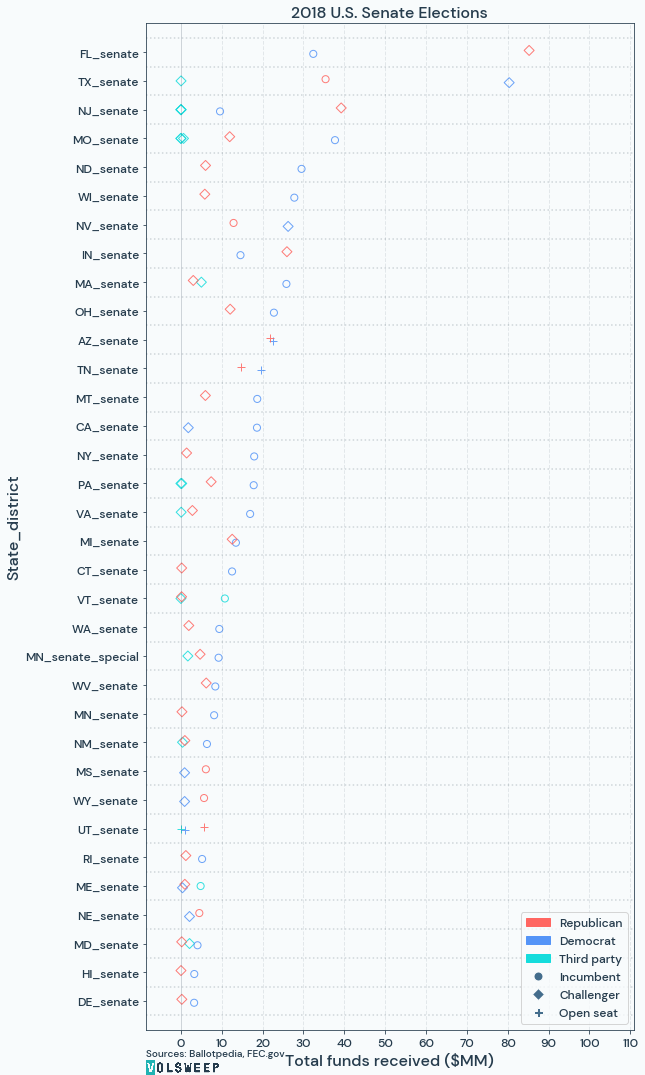

In [10]:
show_lineups(
    df, 
    'S', 
    figsize=(9, 15), 
    yticks=True, 
    title=f'{year} U.S. Senate Elections',
    ylabel='State_district',
    
)

## House

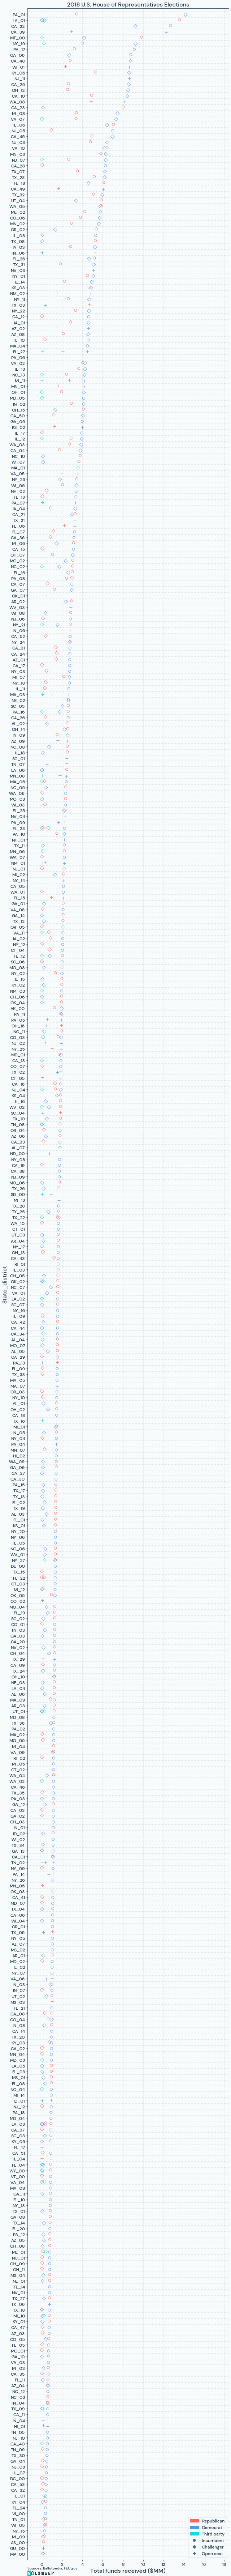

In [11]:
show_lineups(
    df, 
    'H', 
    figsize=(9, 99), 
    yticks=True, 
    title=f'{year} U.S. House of Representatives Elections',
    ylabel='State_district',
    
)

## Group similar contests

In [12]:
pos_df = deepcopy(df)

allcontests = list(set(pos_df['contest']))

clusters = []
for contest in allcontests:
    clusterlet = ''
    lil_df = pos_df[pos_df['contest'] == contest].sort_values(['ttl_receipts'], 
                                                        ascending = False)
    
    if 'I' in lil_df['cand_ici'].values:
        incumb_funds = lil_df.loc[lil_df['cand_ici'] == 'I', 
                                  'ttl_receipts'].values[0]
        incumb_pty = lil_df.loc[lil_df['cand_ici'] == 'I', 
                                'cand_pty_affiliation'].values[0]
        clusterlet += f'{incumb_pty} incumbent,'
        incumb_primary = lil_df[lil_df['cand_pty_affiliation'] == incumb_pty]
        other = lil_df[lil_df['cand_pty_affiliation'] != incumb_pty]
        if len(incumb_primary) > 1:
#             clusterlet += '\nwith primary opponent(s),'
            if incumb_primary['cand_ici'].values[0] != 'I':
                clusterlet += '\nbehind in primary fundraising,'
            else:
                clusterlet += '\nahead in primary fundraising,'
        else:
            clusterlet += '\nno primary,'
        if len(other) > 0:
#             clusterlet += 'yes general, '
            if other['ttl_receipts'].values[0] > incumb_funds:
                clusterlet += '\nbehind in general fundraising,'
            else:
                clusterlet += '\nahead in general fundraising,'
                
#             if len(other) > 1:
#                 clusterlet += '\nopponent primary,'
#             else:
#                 clusterlet += '\nsolo general opponent,'
        else:
            clusterlet += '\nno general opponent,'
            
    else:
        clusterlet += 'no incumbent,'
        lil_rep = lil_df[lil_df['cand_pty_affiliation'] == 'Republican']
        lil_dem = lil_df[lil_df['cand_pty_affiliation'] == 'Democrat']
        if (len(lil_rep) > 0) & (len(lil_dem) > 0):
#             clusterlet += '\nboth parties in, '
            ahead = lil_df['cand_pty_affiliation'].values[0]
            clusterlet += f'\n{ahead} ahead in fundraising,'
        else:
            clusterlet += '\none party;'
#         if len(lil_rep) > 1:
#             clusterlet += '\nrep. primary,'
#         elif len(lil_rep) == 1:
#             clusterlet += '\nrep. solo,'
#         if len(lil_dem) > 1:
#             clusterlet += '\ndem. primary'
#         elif len(lil_dem) == 1:
#             clusterlet += '\ndem. solo'
        
    clusters.append(clusterlet)

clusters = [x[:-1] if ((x[-1] == ',') | (x[-1] == ';')) else x for x in clusters]

contest_df = pd.DataFrame()

contest_df['contest'] = list(set(pos_df['contest']))
contest_df['type'] = clusters

print(len(set(contest_df['type'])))

14


In [13]:
## create type dict and add column of type keys to pos_df
types = list(contest_df['type'].value_counts().index)
type_dict = dict(zip(types, range(1, len(types) + 1)))
pos_df['type'] = [contest_df.loc[contest_df['contest'] == pos_df.loc[i, 'contest'], 'type'].values[0] \
              for i in list(pos_df.index)]
pos_df['type'] = [f'Group {type_dict[x]:02}' for x in pos_df['type']]

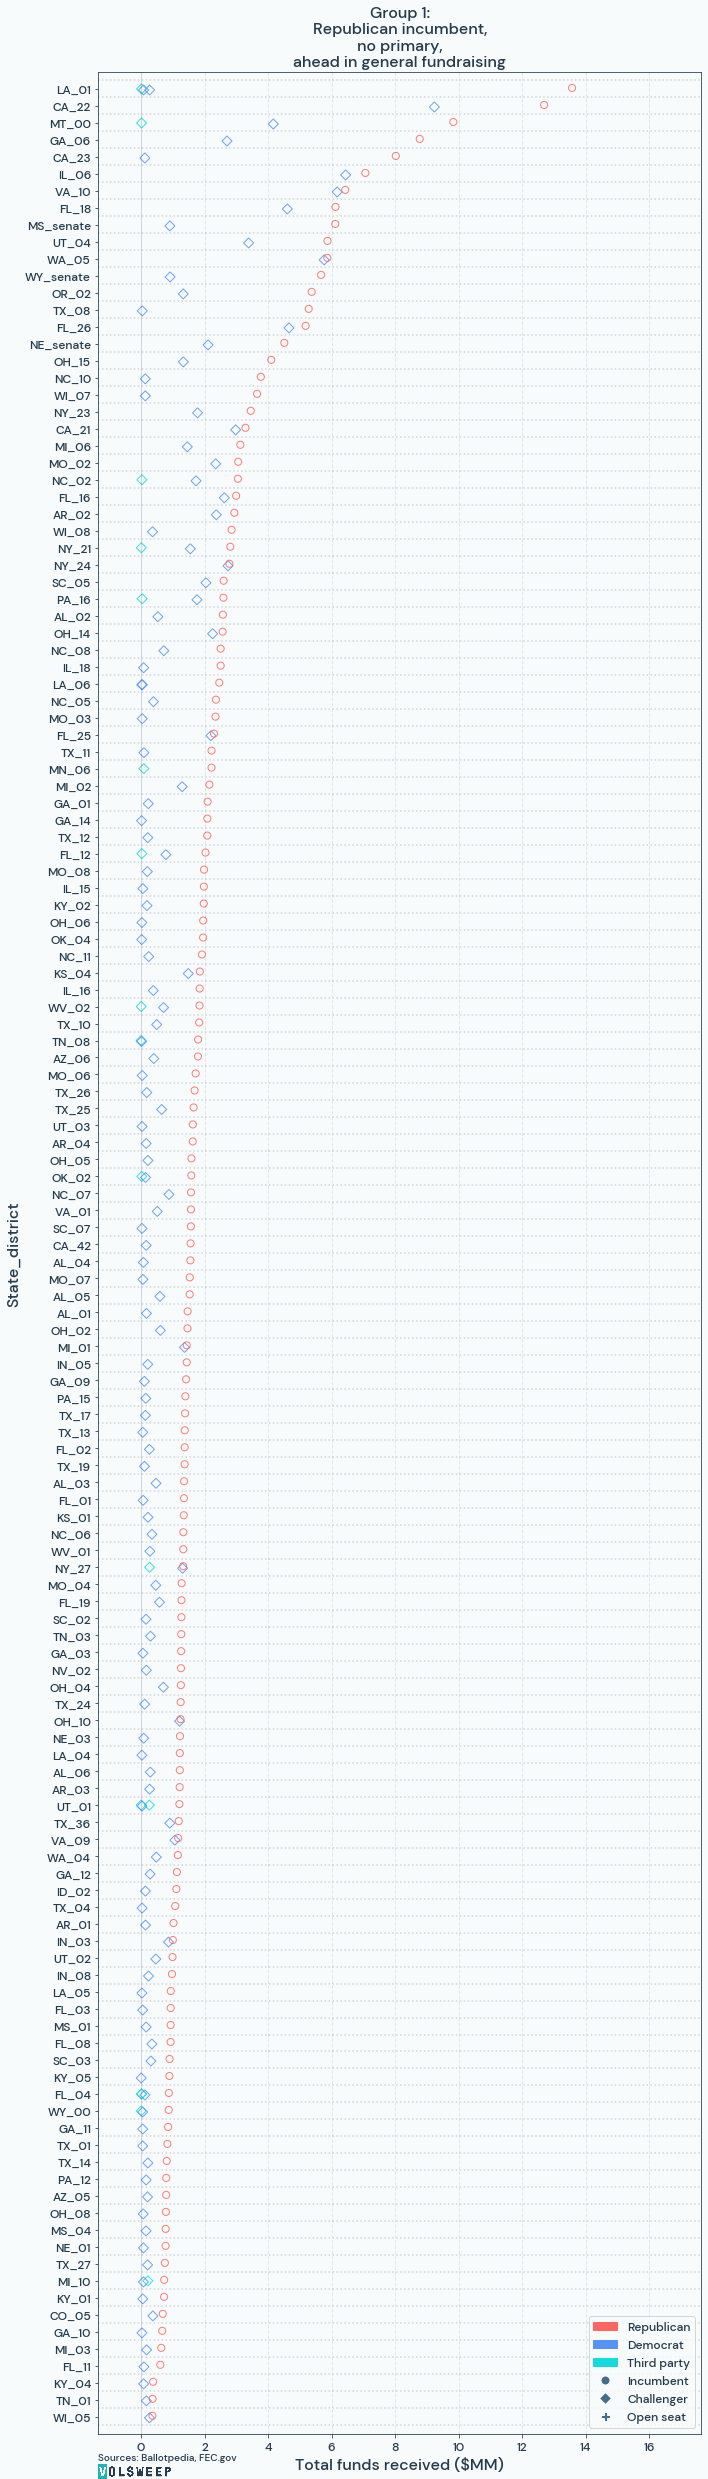

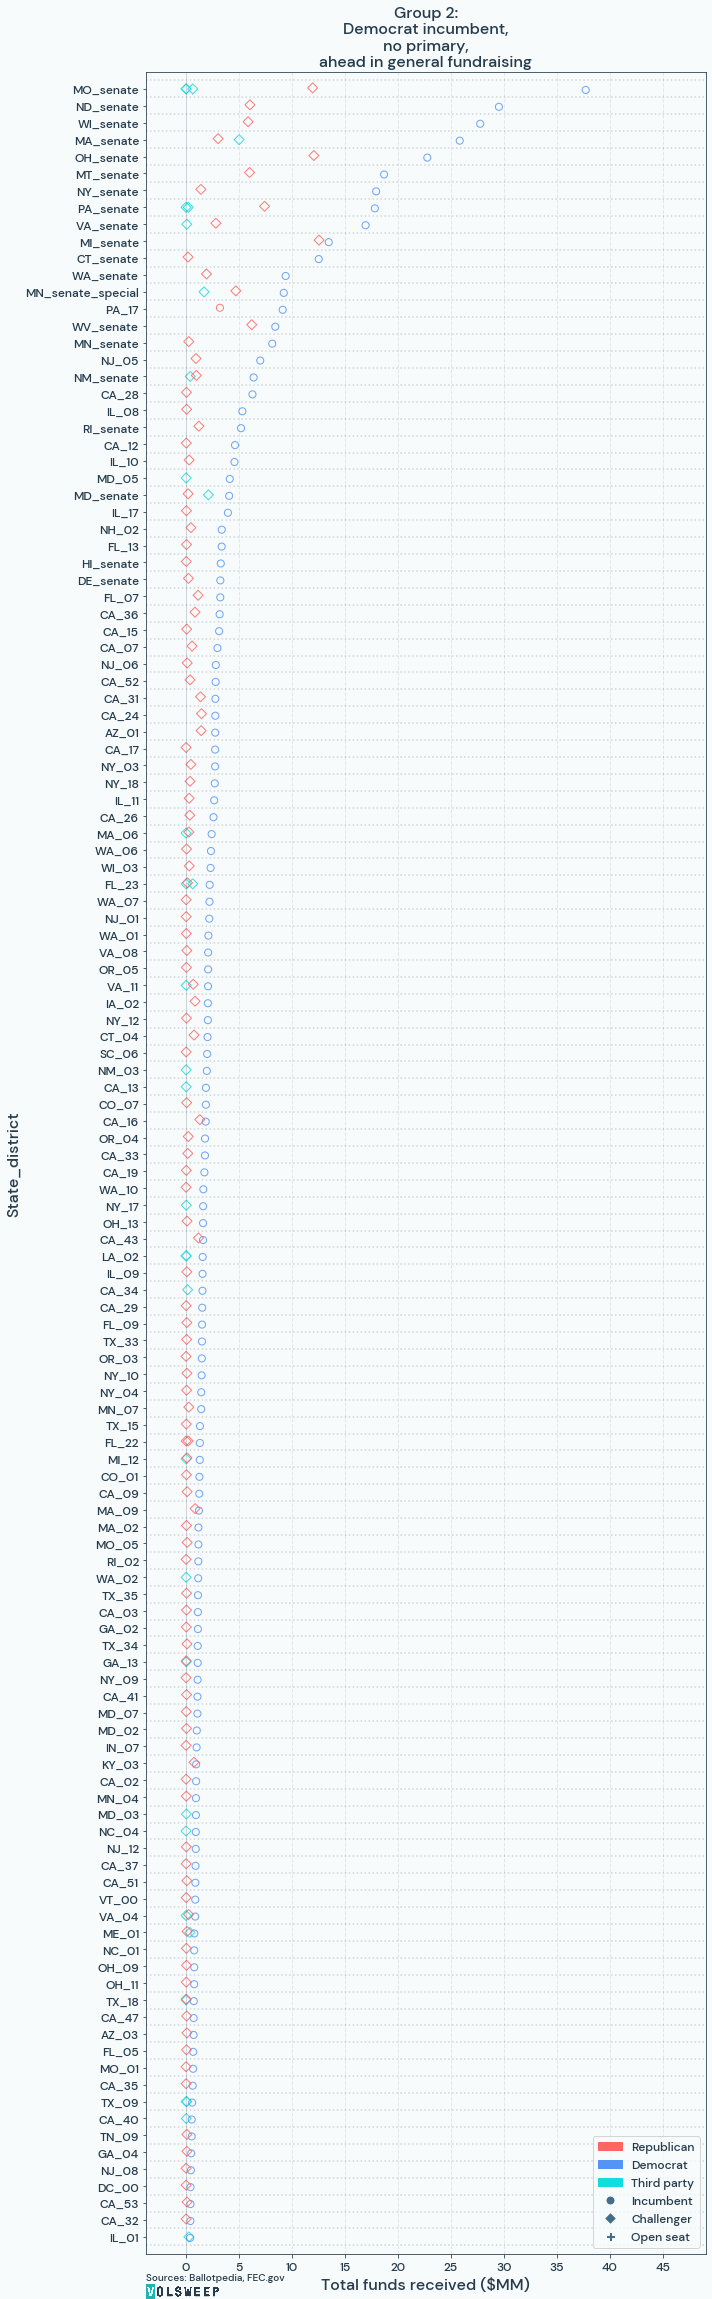

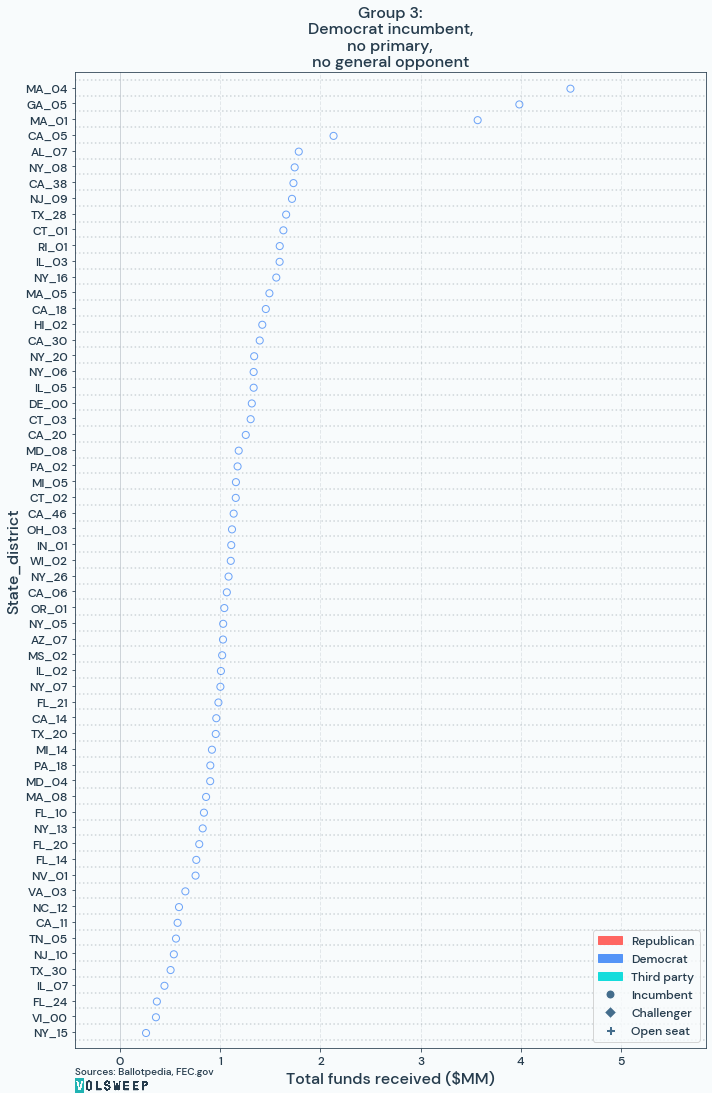

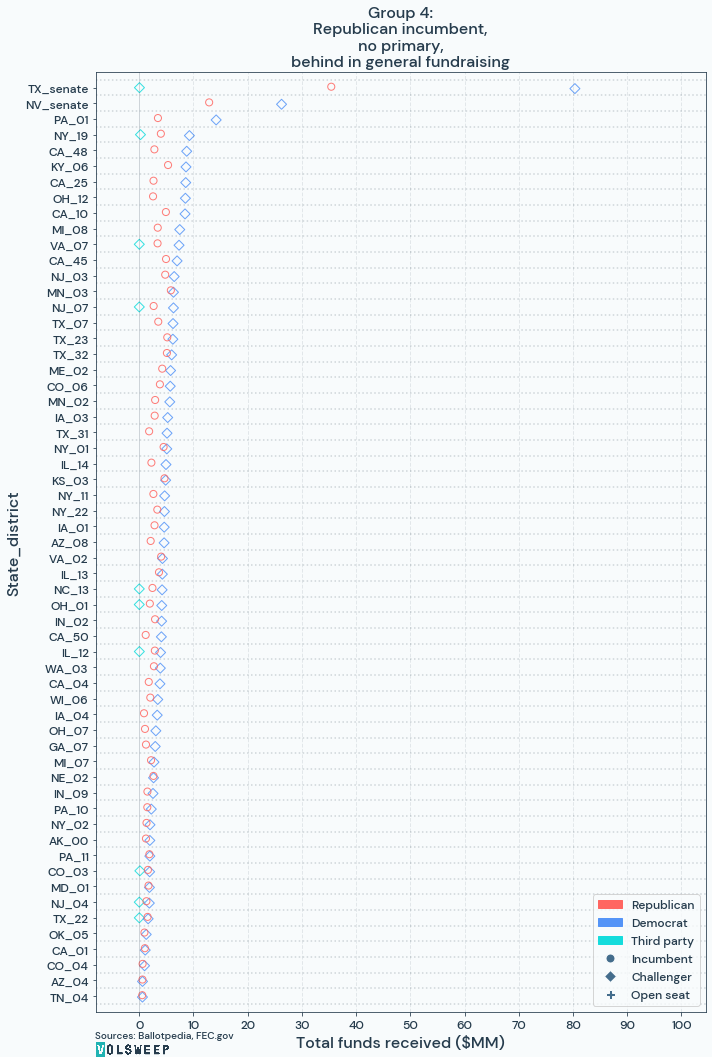

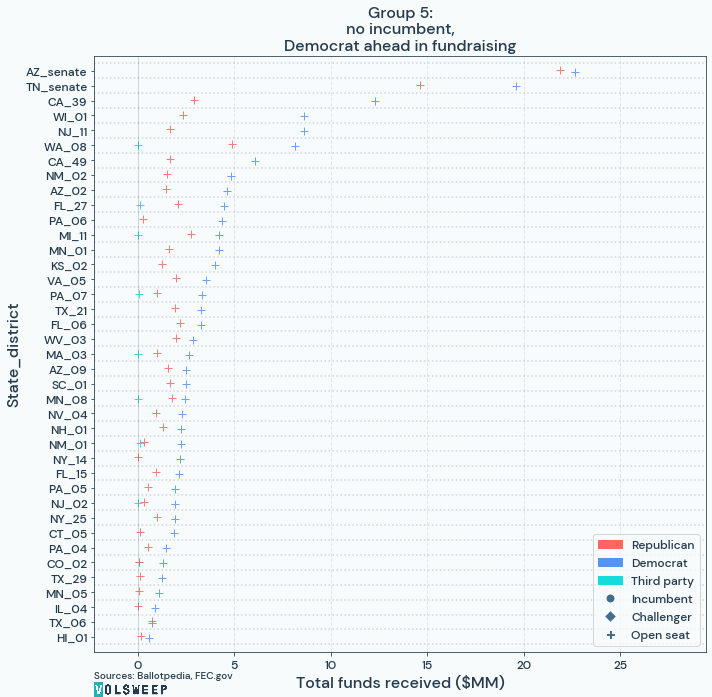

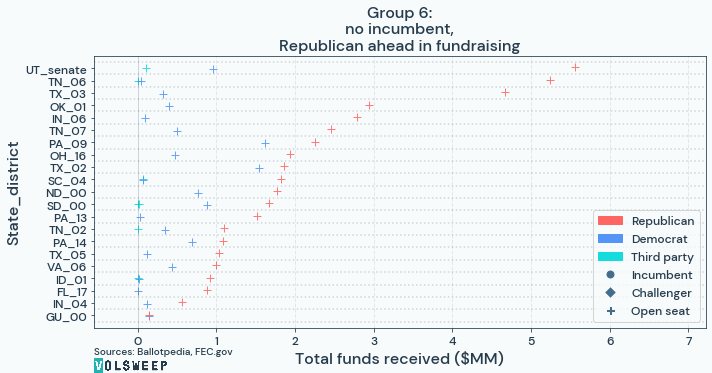

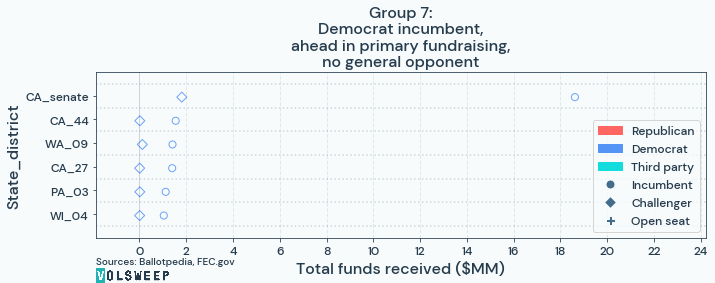

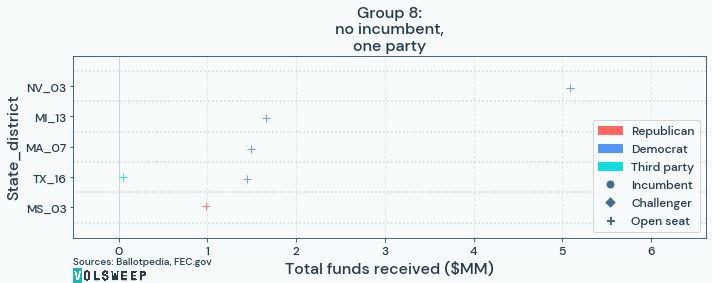

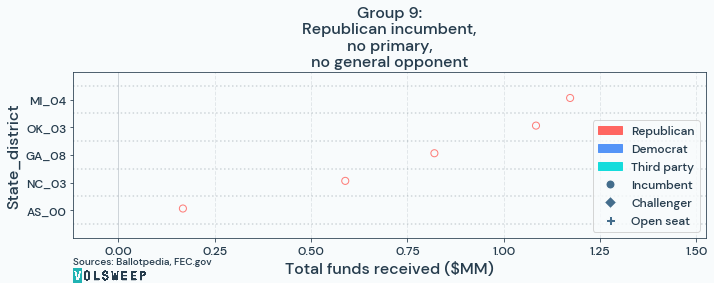

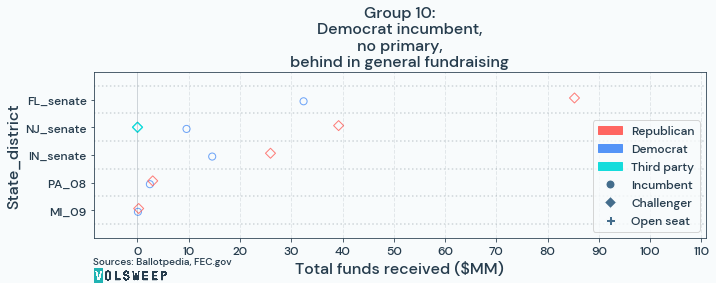

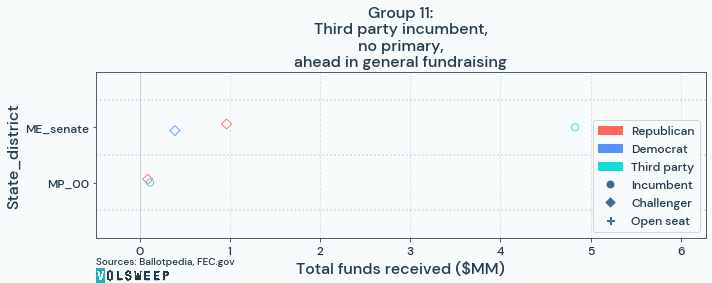

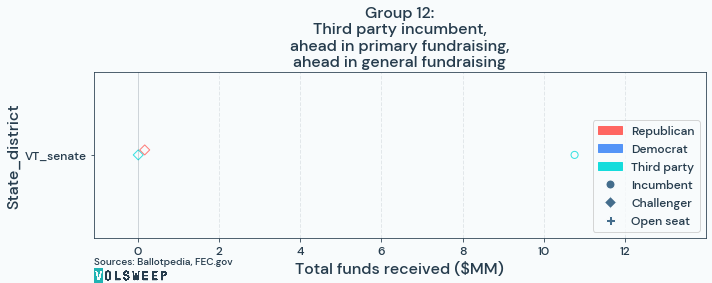

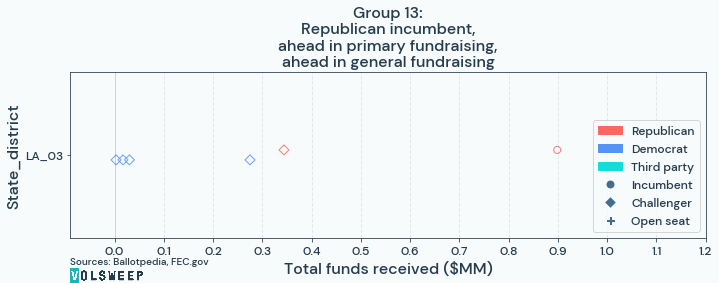

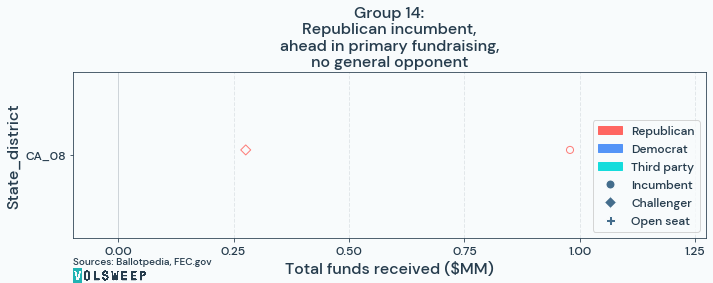

In [14]:
for type_ in types:
    contest_list = contest_df.loc[contest_df['type'] == type_, 'contest'].values
    contests = len(contest_list)
    mask = [True if df.loc[i, 'contest'] in contest_list \
            else False for i in list(df.index)]
    type_df = df[mask]
    if contests < 14:
        contests = 16
    show_lineups(
        type_df, 
        ['S', 'H'], 
        figsize=(10, 0.25*contests), 
        yticks=True, 
        uncontested=True,
        title=f'Group {type_dict[type_]}:\n{type_}',
        ylabel='State_district',
        
    )

In [15]:
these = [

]

In [16]:
pos_df.loc[pos_df['contest'].apply(lambda x: x in these), [
    'cand_id', 
    'contest', 
    'cand_name', 
    'cand_ici', 
    'cand_pty_affiliation', 
    'ttl_receipts']].sort_values(['contest', 'ttl_receipts'], ascending = [True, False])

,cand_id,contest,cand_name,cand_ici,cand_pty_affiliation,ttl_receipts


## By state

In [17]:
# states = [x.split('_')[0] for x in df['contest']]
# df['state'] = states
# df.sort_values(['ttl_receipts'], ascending = False, inplace = True)
# get_states = df.drop_duplicates(['state'])['state'].values
# states = [x for x in get_states if x != 'senate']

# for state in states:
#     print('state:', state)
#     state_df = df[df['state'] == state]
#     contests = len(set(state_df['contest']))
#     if contests < 6:
#         contests = 6
#     show_lineups(
#         state_df, 
#         ['H', 'S'], 
#         figsize=(10, 0.5*contests), 
#         yticks=True, 
#         uncontested=True,
#         title=f'{year} U.S. Congressional Elections in {state}',
#         ylabel='State_district',
        
#     )

In [18]:
# df.loc[df['contest'].apply(lambda x: 'IA' in x), [
#     'cand_id', 
#     'cand_name',
#     'cand_ici',
#     'cand_pty_affiliation',
#     'ttl_receipts',
#     'contest', 
# ]].sort_values(
#     ['contest', 'ttl_receipts'], 
#     ascending = [True, False], 
# )

In [19]:
which_counts = []
for i in range(1, len(types) + 1):
    type_ = f'Group {i:02}'
    lil_type = pos_df[pos_df['type'] == type_]
    lil_count = [type_]
    for which in ['H', 'S']:
        lil_which = lil_type[lil_type['position'] == which].drop_duplicates(['contest'])
        lil_count.extend([len(lil_which)])
    which_counts.append(lil_count)
    
df_counts = pd.DataFrame(which_counts)
df_counts.columns = ['type', 'H', 'S']
df_counts['H'] = df_counts['H']/sum(df_counts['H'])
df_counts['S'] = df_counts['S']/sum(df_counts['S'])
df_counts

,type,H,S
0,Group 01,0.308219,0.088235
1,Group 02,0.246575,0.588235
2,Group 03,0.139269,0.000000
3,Group 04,0.130137,0.058824
4,Group 05,0.084475,0.058824
5,Group 06,0.045662,0.029412
6,Group 07,0.011416,0.029412
7,Group 08,0.011416,0.000000
8,Group 09,0.011416,0.000000
9,Group 10,0.004566,0.088235


In [20]:
df.to_csv('data/01/df_clean_01a.csv', index = False)